In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/DATASET-balanced.csv
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/trump-to-Obama.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/margot-to-musk.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/linus-to-obama.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/taylor-to-trump.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/taylor-to-biden.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/ryan-to-trump.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/obama-to-musk.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/musk-to-trump.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/ryan-to-musk.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/trump-to-musk.wav
/kaggle/input/deep-voice-deepfake-

# Import Libraries

In [2]:
!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.8 MB/s eta 0:00:0000:0100:01


In [30]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import IPython
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation, Dropout, Conv2D, MaxPool2D, Flatten, GRU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Load Data

In [4]:
audio_files_path = "/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/"

In [5]:
folders = os.listdir(audio_files_path)
print(folders)

['FAKE', 'REAL']


In [6]:
real_audio = "/kaggle/input/deep-voice-deepfake-voice-recognition/DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3"
fake_audio = "/kaggle/input/deep-voice-deepfake-voice-recognition/DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3"

# Visualization

In [7]:
print("Real Audio:")
#IPython.display.Audio(real_audio)

Real Audio:


In [8]:
print("Fake Audio:")
#IPython.display.Audio(fake_audio)

Fake Audio:


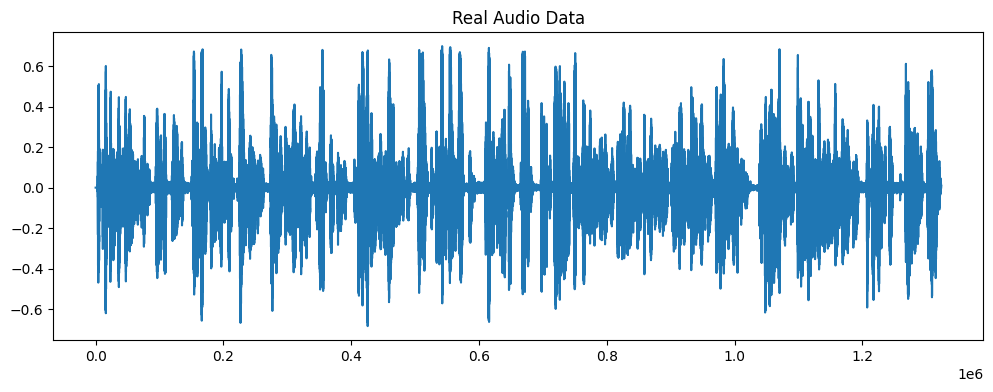

In [9]:
real_ad, real_sr = librosa.load(real_audio)
plt.figure(figsize=(12, 4))
plt.plot(real_ad)
plt.title("Real Audio Data")
plt.show()

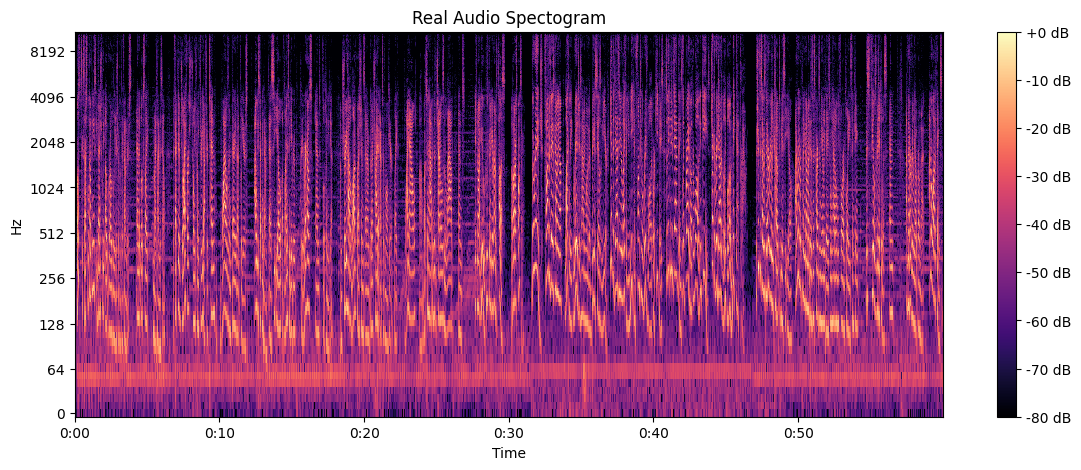

In [10]:
real_spec = np.abs(librosa.stft(real_ad))
real_spec = librosa.amplitude_to_db(real_spec, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_spec, sr=real_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Real Audio Spectogram")
plt.show()

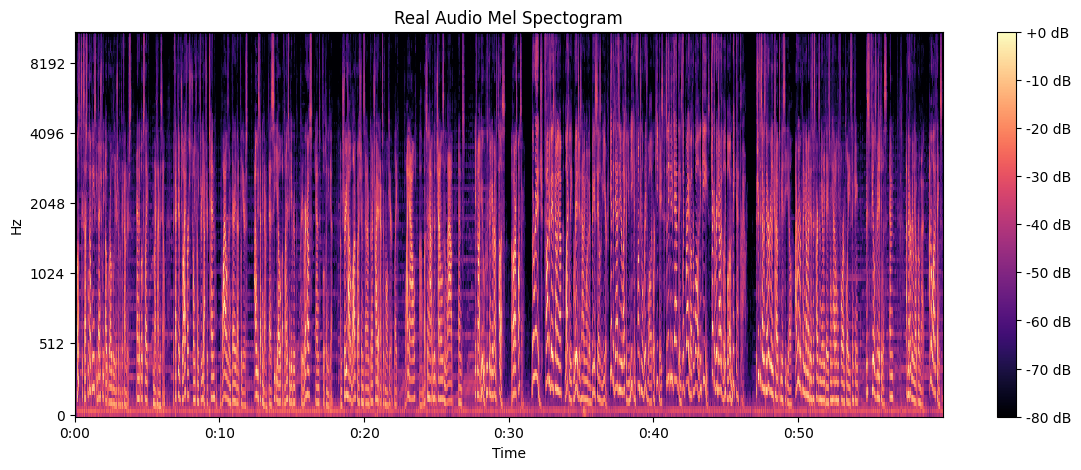

In [11]:
real_mel_spect = librosa.feature.melspectrogram(y=real_ad, sr=real_sr)
real_mel_spect = librosa.power_to_db(real_mel_spect, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_mel_spect, y_axis="mel", x_axis="time")
plt.title("Real Audio Mel Spectogram")
plt.colorbar(format="%+2.0f dB")
plt.show()

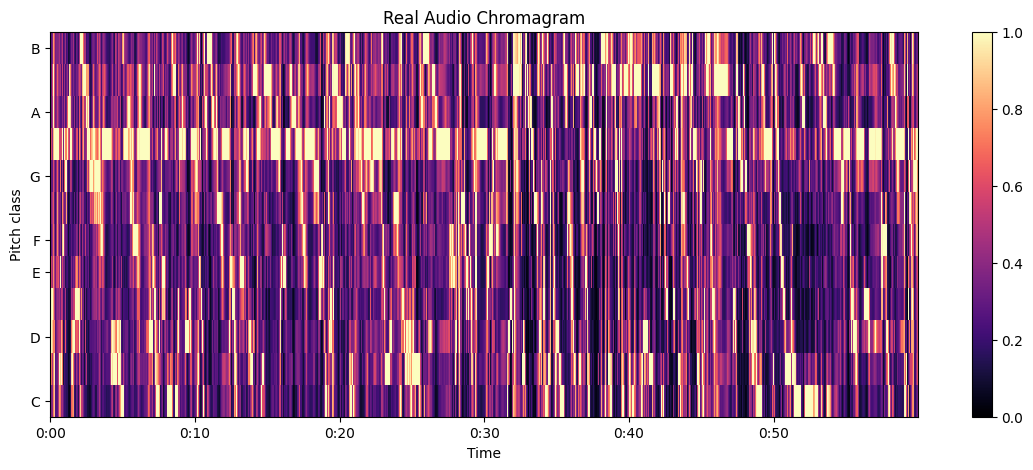

In [12]:
real_chroma = librosa.feature.chroma_cqt(y=real_ad, sr=real_sr, bins_per_octave=36)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_chroma, sr=real_sr, x_axis="time", y_axis="chroma", vmin=0, vmax=1)
plt.colorbar()
plt.title("Real Audio Chromagram")
plt.show()

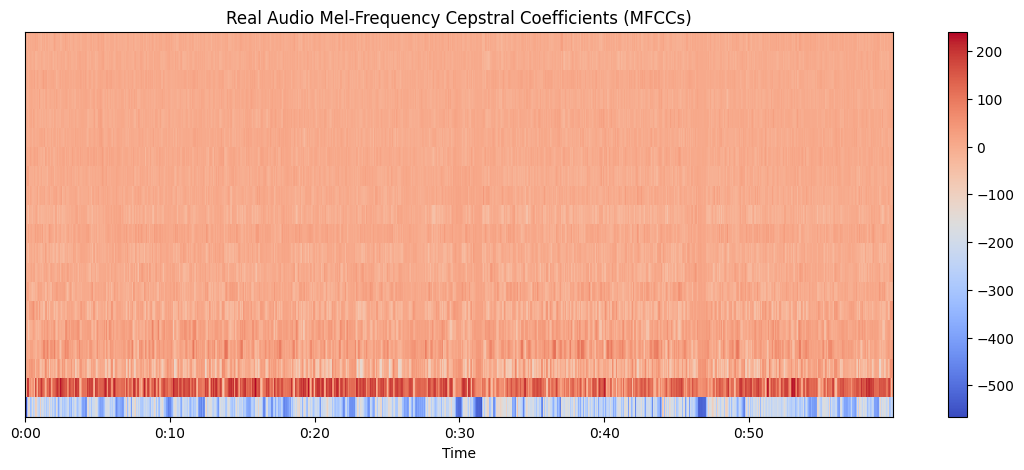

In [13]:
real_mfccs = librosa.feature.mfcc(y=real_ad, sr=real_sr)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_mfccs, sr=real_sr, x_axis="time")
plt.colorbar()
plt.title("Real Audio Mel-Frequency Cepstral Coefficients (MFCCs)")
plt.show()

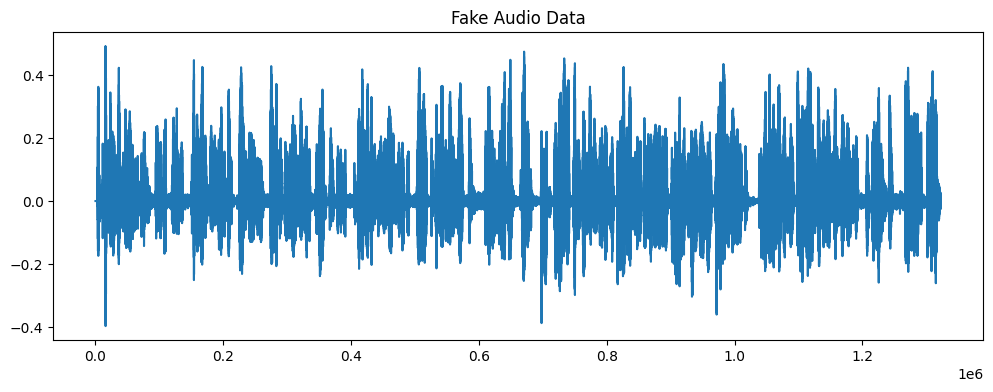

In [14]:
fake_ad, fake_sr = librosa.load(fake_audio)
plt.figure(figsize=(12, 4))
plt.plot(fake_ad)
plt.title("Fake Audio Data")
plt.show()

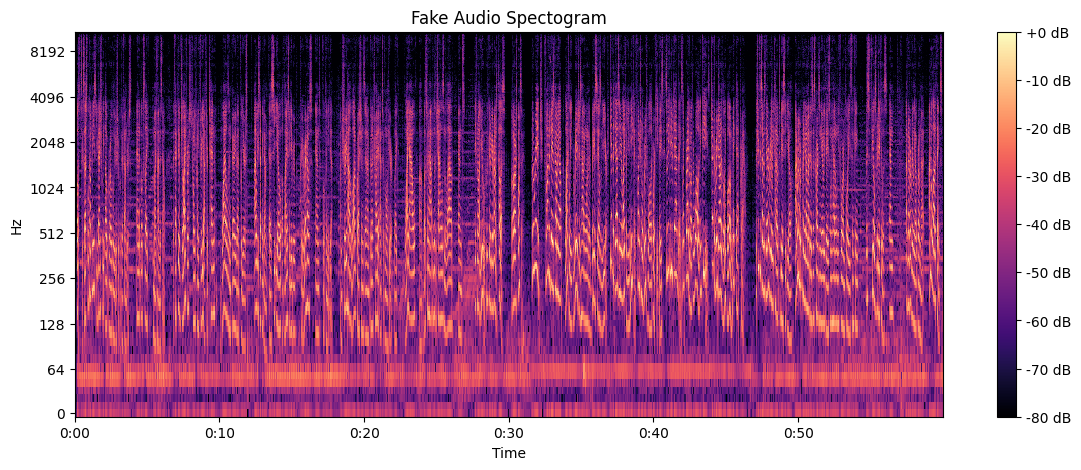

In [15]:
fake_spec = np.abs(librosa.stft(fake_ad))
fake_spec = librosa.amplitude_to_db(fake_spec, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_spec, sr=fake_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Fake Audio Spectogram")
plt.show()

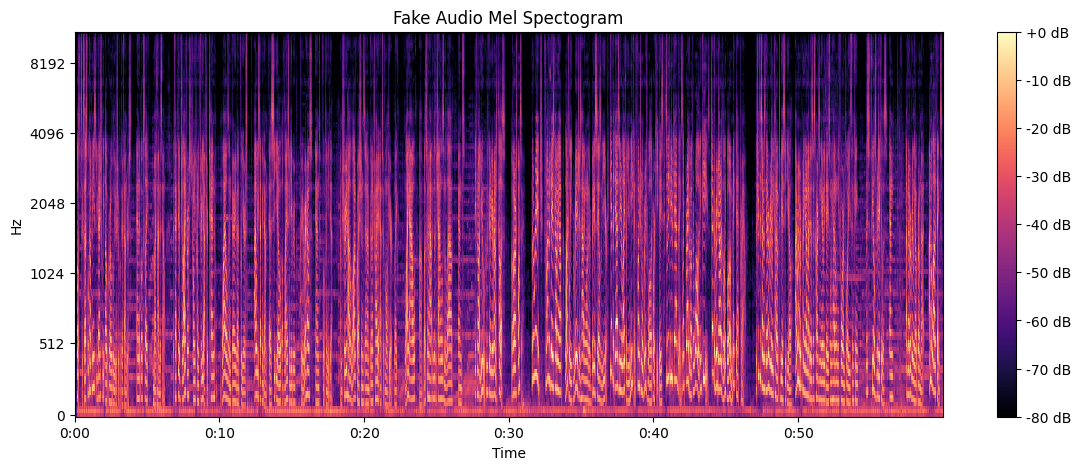

In [16]:
fake_mel_spect = librosa.feature.melspectrogram(y=fake_ad, sr=fake_sr)
fake_mel_spect = librosa.power_to_db(fake_mel_spect, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_mel_spect, y_axis="mel", x_axis="time")
plt.title("Fake Audio Mel Spectogram")
plt.colorbar(format="%+2.0f dB")
plt.show()

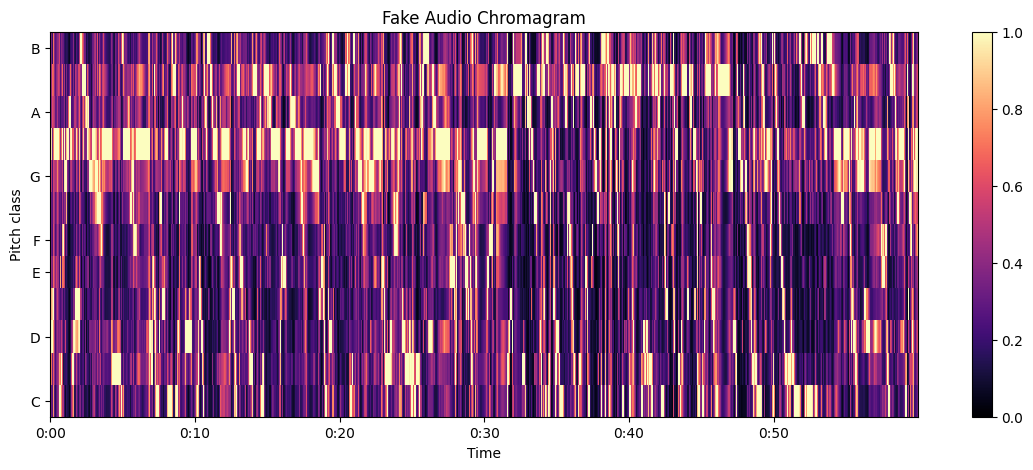

In [17]:
fake_chroma = librosa.feature.chroma_cqt(y=fake_ad, sr=fake_sr, bins_per_octave=36)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_chroma, sr=fake_sr, x_axis="time", y_axis="chroma", vmin=0, vmax=1)
plt.colorbar()
plt.title("Fake Audio Chromagram")
plt.show()

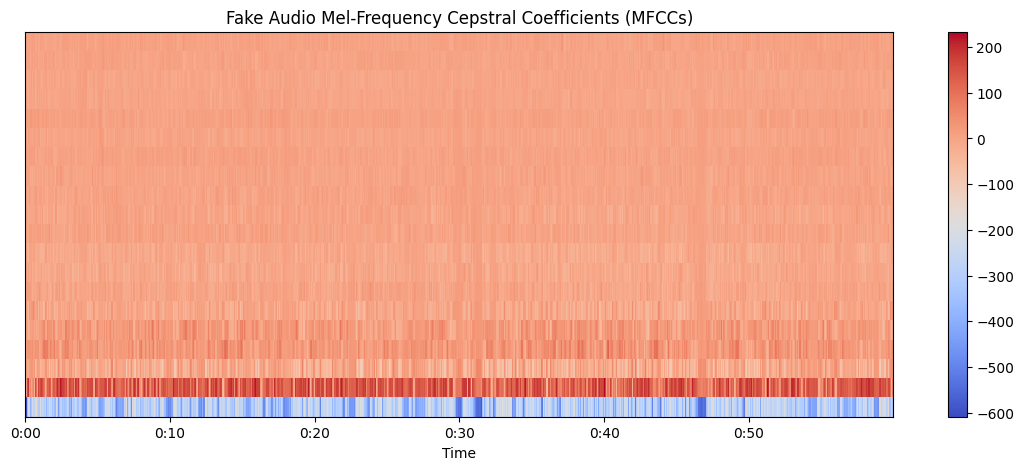

In [18]:
fake_mfccs = librosa.feature.mfcc(y=fake_ad, sr=fake_sr)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_mfccs, sr=fake_sr, x_axis="time")
plt.colorbar()
plt.title("Fake Audio Mel-Frequency Cepstral Coefficients (MFCCs)")
plt.show()

# Preprocess

In [19]:
data = []
labels = []

for folder in folders:
    files = os.listdir(os.path.join(audio_files_path, folder))
    for file in tqdm(files):
        file_path = os.path.join(audio_files_path, folder, file)
        audio, sample_rate = librosa.load(file_path, res_type="kaiser_fast")
        mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_features_scaled = np.mean(mfccs_features.T, axis=0)
        data.append(mfccs_features_scaled)
        labels.append(folder)

100%|██████████| 8/8 [00:59<00:00,  7.40s/it]


In [20]:
feature_df = pd.DataFrame({"features": data, "class": labels})
feature_df.head()

,features,class
0,"[-291.10123, 95.36503, -13.482852, 10.591423, ...",FAKE
1,"[-250.76636, 117.728546, -22.377504, 30.396112...",FAKE
2,"[-256.0186, 108.66988, 2.0284197, 24.126278, 2...",FAKE
3,"[-295.43436, 76.94639, -0.6353918, 17.214228, ...",FAKE
4,"[-288.0438, 75.1327, 1.3050734, 20.612984, -2....",FAKE


In [21]:
feature_df["class"].value_counts()

class
FAKE    56
REAL     8
Name: count, dtype: int64

In [22]:
def label_encoder(column):
    le = LabelEncoder().fit(column)
    print(column.name, le.classes_)
    return le.transform(column)

In [23]:
feature_df["class"] = label_encoder(feature_df["class"])

class ['FAKE' 'REAL']


# Feature Scaling

In [24]:
X = np.array(feature_df["features"].tolist())
y = np.array(feature_df["class"].tolist())

In [25]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [26]:
y_resampled = to_categorical(y_resampled)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [28]:
num_labels = len(feature_df["class"].unique())
num_labels

2

In [29]:
input_shape = feature_df["features"][0].shape
input_shape

(40,)

# Model

In [33]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.00001,
)

In [34]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_shape = input_shape, activation='relu'),
    tf.keras.layers.Dense(128, input_shape = input_shape, activation='relu'),
    tf.keras.layers.Dense(128, input_shape = input_shape, activation='relu'),    
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               10496     
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 2)                 258       
                                                                 
Total params: 60162 (235.01 KB)
Trainable params: 60162 (235.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"], )

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               10496     
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 2)                 258       
                                                                 
Total params: 60162 (235.01 KB)
Trainable params: 60162 (235.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
early = EarlyStopping(monitor="val_loss", patience=150)

In [38]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=4, epochs=200, callbacks=[early])

Epoch 1/200
23/23 [==============================] - 3s 14ms/step - loss: 3.0636 - accuracy: 0.5506 - val_loss: 0.8138 - val_accuracy: 0.5652
Epoch 2/200
23/23 [==============================] - 0s 4ms/step - loss: 0.8799 - accuracy: 0.6517 - val_loss: 0.8478 - val_accuracy: 0.5217
Epoch 3/200
23/23 [==============================] - 0s 4ms/step - loss: 0.6858 - accuracy: 0.6629 - val_loss: 0.9632 - val_accuracy: 0.5217
Epoch 4/200
23/23 [==============================] - 0s 4ms/step - loss: 0.7212 - accuracy: 0.6742 - val_loss: 1.0362 - val_accuracy: 0.4348
Epoch 5/200
23/23 [==============================] - 0s 4ms/step - loss: 0.6345 - accuracy: 0.6404 - val_loss: 0.4322 - val_accuracy: 0.7391
Epoch 6/200
23/23 [==============================] - 0s 4ms/step - loss: 0.8389 - accuracy: 0.6742 - val_loss: 0.8533 - val_accuracy: 0.6522
Epoch 7/200
23/23 [==============================] - 0s 4ms/step - loss: 0.5891 - accuracy: 0.7079 - val_loss: 0.5964 - val_accuracy: 0.6522
Epoch 8/200


In [40]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

1/1 [==============================] - 0s 24ms/step - loss: 0.1334 - accuracy: 0.9565
Test Loss: 0.13344143331050873
Test Accuracy: 0.95652174949646


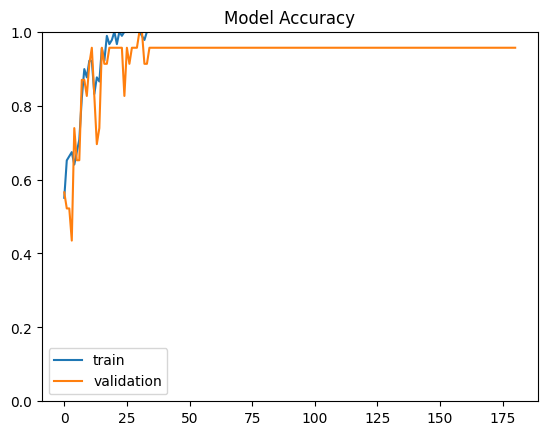

In [41]:
plt.figure()
plt.title("Model Accuracy")
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

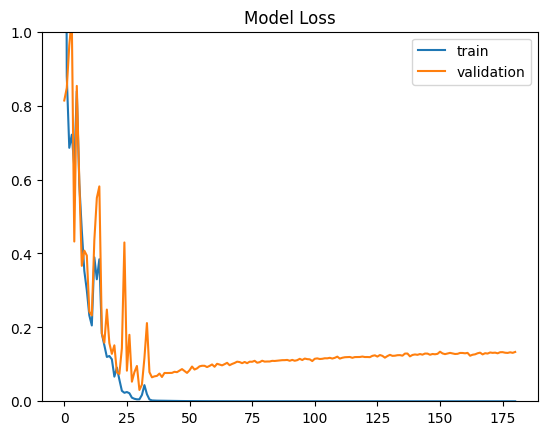

In [42]:
plt.figure()
plt.title("Model Loss")
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

# Test

In [43]:
def detect_fake(filename):
    sound_signal, sample_rate = librosa.load(filename, res_type="kaiser_fast")
    mfcc_features = librosa.feature.mfcc(y=sound_signal, sr=sample_rate, n_mfcc=40)
    mfccs_features_scaled = np.mean(mfcc_features.T, axis=0)
    mfccs_features_scaled = mfccs_features_scaled.reshape(1, -1)
    result_array = model.predict(mfccs_features_scaled)
    print(result_array)
    result_classes = ["FAKE", "REAL"]
    result = np.argmax(result_array[0])
    print("Result:", result_classes[result])

In [44]:
test_real = "/kaggle/input/deep-voice-deepfake-voice-recognition/DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3"
test_fake = "/kaggle/input/deep-voice-deepfake-voice-recognition/DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3"

In [45]:
detect_fake(test_real)

1/1 [==============================] - 0s 117ms/step
[[1.1831993e-12 1.0000000e+00]]
Result: REAL


In [46]:
detect_fake(test_fake)

1/1 [==============================] - 0s 37ms/step
[[9.999999e-01 7.379336e-08]]
Result: FAKE


In [56]:
detect_fake('/kaggle/input/audio-cyber/Audio/Real/New-recording-60.wav')

1/1 [==============================] - 0s 37ms/step
[[0.01494263 0.9850574 ]]
Result: REAL


In [50]:
#Save the model architecture as JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights
model.save_weights("model_weights.h5")